In [2]:
from datetime import datetime as dt
from preprocessing import Preprocessing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, RocCurveDisplay
from imblearn.under_sampling import RandomUnderSampler

In [3]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [75]:
from keras import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.metrics import AUC
from keras.optimizers.legacy import Adam
from keras.callbacks import EarlyStopping
from keras.losses import BinaryFocalCrossentropy
from keras.regularizers import l2

In [ ]:
def plot_history(history, metric='accuracy'):
    x = range(1, len(history.history[metric]) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    
    plt.plot(history.history['loss'], 'b', label='Training loss')
    plt.plot(history.history['val_loss'], 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history[metric], 'b', label='Training accuracy')
    plt.plot(history.history[f'val_{metric}'],'r', label='Validation accuracy')
    plt.title('Training and validation auc')
    plt.legend()

# Preprocessing

In [5]:
col_drop = ['CustomerId','Surname']
types = {
    'HasCrCard':bool,
    'IsActiveMember':bool
}
train = pd.read_csv('data/train.csv', index_col='id', dtype=types).drop(columns=col_drop)
test = pd.read_csv('data/test.csv', index_col='id', dtype=types).drop(columns=col_drop)

In [6]:
train.shape

(165034, 11)

In [7]:
X = train.drop(columns='Exited')
y = train.Exited

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

In [9]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [10]:
y_resampled.value_counts(True)

Exited
0    0.5
1    0.5
Name: proportion, dtype: float64

In [11]:
prepro = Preprocessing()

In [12]:
X_train_scld = prepro.fit_transform(X_resampled).astype(float)
X_test_scld = prepro.transform(X_test).astype(float)

In [13]:
X_train_scld

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
id,,,,,,,,,,,,
61983,-0.442478,1.0,0.083333,-1.00,1.184432,1.0,1.0,0.0,0.576480,0.0,1.0,0.0
163947,0.194690,1.0,-0.666667,0.25,0.000000,1.0,1.0,0.0,0.264007,1.0,0.0,0.0
112614,-0.327434,1.0,2.833333,1.00,1.020563,1.0,1.0,1.0,-0.822888,1.0,0.0,0.0
156594,-0.247788,0.0,1.666667,-0.25,0.000000,1.0,1.0,1.0,0.550116,1.0,0.0,0.0
70645,-0.601770,1.0,-0.583333,0.50,0.000000,1.0,1.0,1.0,-0.448231,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
159203,-0.380531,0.0,-0.583333,-1.25,1.004552,0.0,0.0,1.0,-0.044463,0.0,0.0,1.0
74782,-0.734513,0.0,0.916667,-0.75,0.000000,3.0,1.0,1.0,-0.720013,1.0,0.0,0.0
34349,0.646018,0.0,0.500000,-1.00,1.316535,0.0,1.0,0.0,0.638879,0.0,1.0,0.0


# Model

In [14]:
X_train_scld.shape

(52382, 12)

In [85]:
model = Sequential(name="BankChurn")
model.add(Dense(units=128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01), input_dim=12, name="Dense1"))
model.add(BatchNormalization(name="BatchNorm1"))
model.add(Dropout(0.1, name="Dropout1"))

model.add(Dense(units=64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01), name="Dense2"))
model.add(BatchNormalization(name="BatchNorm2"))
model.add(Dropout(0.1, name="Dropout2"))

model.add(Dense(units=32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01), name="Dense3"))
model.add(BatchNormalization(name="BatchNorm3"))
model.add(Dropout(0.1, name="Dropout3"))

model.add(Dense(units=16, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01), name="Dense4")) 
model.add(BatchNormalization(name="BatchNorm4"))

model.add(Dense(units=1, activation='sigmoid',kernel_initializer='glorot_uniform',  name="Output"))



model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=[AUC(name='auc')]
    )

early_stopping = EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scld.values,
    y_resampled.values,
    epochs=50,
    batch_size=32,
    validation_split=0.3,
    callbacks=[early_stopping]
    )

Epoch 1/50
1146/1146 [==============================] - 53s 45ms/step - loss: 5.3402 - auc: 0.5832 - val_loss: 4.9572 - val_auc: 0.0000e+00
Epoch 2/50
1146/1146 [==============================] - 52s 46ms/step - loss: 4.9372 - auc: 0.6924 - val_loss: 4.6528 - val_auc: 0.0000e+00
Epoch 3/50
1146/1146 [==============================] - 52s 46ms/step - loss: 4.6464 - auc: 0.7360 - val_loss: 4.4370 - val_auc: 0.0000e+00
Epoch 4/50
1146/1146 [==============================] - 53s 47ms/step - loss: 4.3887 - auc: 0.7533 - val_loss: 4.2120 - val_auc: 0.0000e+00
Epoch 5/50
1146/1146 [==============================] - 54s 47ms/step - loss: 4.1478 - auc: 0.7675 - val_loss: 4.0317 - val_auc: 0.0000e+00
Epoch 6/50
1146/1146 [==============================] - 51s 45ms/step - loss: 3.9194 - auc: 0.7766 - val_loss: 3.8196 - val_auc: 0.0000e+00
Epoch 7/50
1146/1146 [==============================] - 51s 44ms/step - loss: 3.7075 - auc: 0.7819 - val_loss: 3.6575 - val_auc: 0.0000e+00
Epoch 8/50
1146/1146

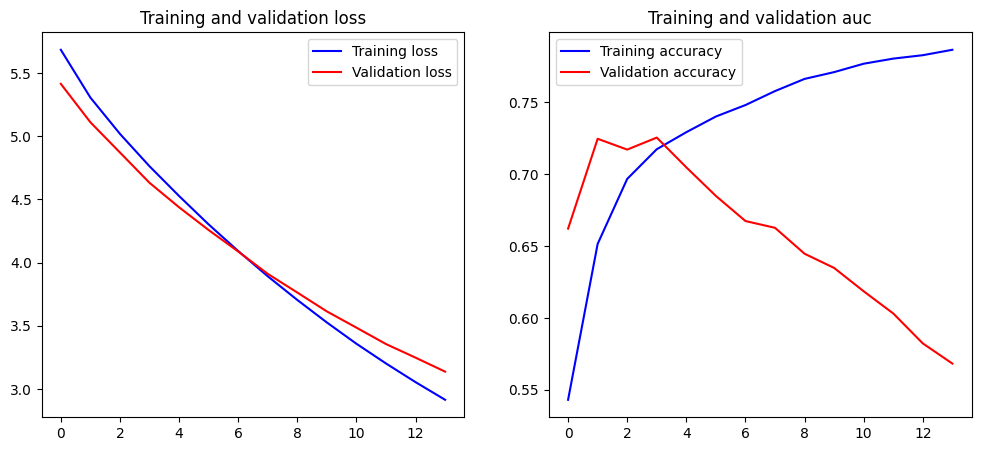

In [ ]:
plot_history(history, 'auc')

In [79]:
pred = model.predict(X_test_scld.values)

1290/1290 [==============================] - 4s 3ms/step


In [80]:
pred[:,0]

array([0.8159248 , 0.09124052, 0.45246008, ..., 0.3086771 , 0.2069842 ,
       0.19893448], dtype=float32)

# Score

In [81]:
RocScore  = roc_auc_score(y_test, pred[:,0])
print(f'Roc Auc Score : {RocScore:.6f}')

Roc Auc Score : 0.814240


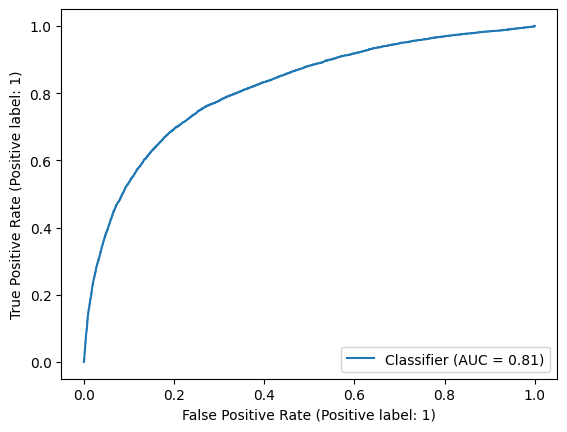

In [82]:
RocCurveDisplay.from_predictions(y_test,pred)

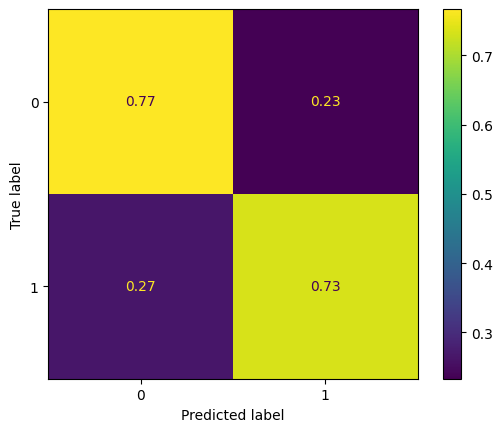

In [74]:
ConfusionMatrixDisplay(confusion_matrix(y_test,pred[:,0]>0.5, normalize='true')).plot()

# Submission

In [ ]:
X_val_scld = prepro.transform(test)

In [ ]:
submission = pd.read_csv("data/sample_submission.csv", index_col='id')

In [ ]:
submission.loc[:,'Exited'] = nn.predict_proba(X_val_scld)[:,1]

/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


In [ ]:
submission

,Exited
id,
165034,0.085936
165035,0.947197
165036,0.079534
165037,0.519489
165038,0.638603
...,...
275052,0.132850
275053,0.217605
275054,0.071276


In [ ]:
name = dt.now().strftime("%Y%m%d_%H%M")

In [ ]:
#submission.to_csv(f"submission/{name}.csv")